# Прогнозирование оттока клиента оператора связи

**Описание целей и задачи проекта**

Заказчик оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Необходимо создать классифицирующую модель, предсказывающую вероятнотность того, что клиент планирует уйти или остаться. 


**Описание данных**

В распоряжении информация о договорах актуальных на 1 февраля 2020. Данные представлены в 4 таблицах:

Таблица **contract** — информация о договоре:
 - customerID код клиента
 - BeginDate дата, кода клиент начал пользоваться услугами компании
 - EndDate дата, кода клиент закончил пользоваться услугами компании 
 - Type период оплаты
 - PaperlessBilling возможность получения электронного чека
 - PaymentMethod способ оплаты
 - MonthlyCharges стоимость услуг за месяц
 - TotalCharges общая выручка за все услуги с клиента


Таблица **personal** — персональные данные клиента:
 - customerID код клиента
 - gender пол
 - SeniorCitizen пожилой человек (возраст 65+)
 - Partner семейное положение (в браке)
 - Dependents количество детей

Таблица **internet** — информация об интернет-услугах:
 - customerID код клиента
 - InternetService тип подключения интернета
 - OnlineSecurity подключение блокировки небезопасных сайтов
 - OnlineBackup подключение облачного хранилища
 - DeviceProtection подключение интернет-безопасности
 - TechSupport подключение к выделенной линии технической поддержки
 - StreamingTV подключение к стриминговому телевидинию
 - StreamingMovies поключение к каталогу фильмов
 
Таблица **phone** — информация об услугах телефонии:
 - customerID код клиента
 - MultipleLines подключение телефонного аппарата к нескольким линиям одновременно

**План работы**

 - изучение и предобработка данных
     - загрузка и ознакомление
     - приведение к общему "питоновскому стилю"
     - работа с пропусками и дубликатами
     - приведение к нужным типам данных
     - определение целевой переменной
 -  работа с признаками
     - исключение ненужных признаков
     - формирование новых признаков
     - анализ дисбаланса целевого класса
     - объединение таблиц в одну и работа с новыми пропусками
     - проверка корреляции признаков и корреляции с целевым признаком
 - разбивка данных обучающую и тестовую выборки
 - обучить минимум две модели на разных алгоритмах
     - подготовка признаков для каждой модели
     - подборгиперпараметров на кросвалидации
 - AUC-ROC мера на тестовой выборке должна быть не ниже 0.85, так же необходимо посчитать F1 и accuracu
 - тест лучшей модели и проверка на адекватность
 - анализ важности признаков выбранной модели
 - выводы по исследованию
 
 
Данное исследование позволит определить, какие параметры влияют на лояльность клиентов. Помогут понять в каких направлениях стоит разработать нововведения. Какие услуги можно предложить клиентам со скидками для их удержания в компании. В результате данной работы получится модель, которая предскажет с какими клиентами необходимо дополнительно взаимодействие, чтобы их сохранить. И как результат сохранить и увеличить прибыль компании.

## Ознакомление с информацией

Начнем с блока импорта библиотек и далее поочередно загрузим и ознкомимся со всеми таблицами.

In [1]:
# импортируем нужные библиотеки
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt

# для моделей
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

### Информация о договоре

Згарузка и ознакомление.

In [2]:
# пути к файлу
pth1 = '/datasets/final_provider/contract.csv'
pth2 = '/Users/refresh/Downloads/final_provider/contract.csv'
# открытие файла
if os.path.exists(pth1):
    contract = pd.read_csv(pth1)
elif os.path.exists(pth2):
    contract = pd.read_csv(pth2)
else:
    print('Что-то пошло не так')
    
# информация о таблице
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
# вывод 3х случайных строчек
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2369,9570-KYEUA,2014-10-01,No,Two year,No,Credit card (automatic),99.25,6549.45
6997,2523-EWWZL,2017-11-01,No,Month-to-month,Yes,Electronic check,76.10,2093.4
6943,0032-PGELS,2019-10-01,2019-11-01 00:00:00,Month-to-month,No,Bank transfer (automatic),30.50,30.5


In [4]:
# описание данных по столбцам
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Видно, что данные имеют разный вид, приведём всё к "змеиному регистру". И проверим на явные дубликаты.

In [5]:
# переименование столбцов
contract = contract.rename(columns = {'customerID' : 'customer_id',
                                      'BeginDate' : 'begin_date',
                                      'EndDate' : 'end_date',
                                      'Type' : 'type',
                                      'PaperlessBilling' : 'paperless_billing',
                                      'PaymentMethod' : 'payment_method',
                                      'MonthlyCharges' : 'monthly_charges',
                                      'TotalCharges' : 'total_charges'})
# понижаем регистр
dict_to_low = ['customer_id', 'end_date', 'type', 'paperless_billing', 'payment_method']
contract[dict_to_low] = contract[dict_to_low].apply(lambda x: x.astype(str).str.lower())
display(contract.sample(3))
# проверка на дубликаты
print('Дубликатов в таблице contract', contract.duplicated().sum())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
5461,1221-ghzep,2014-12-01,no,two year,yes,mailed check,65.10,3846.75
4066,4872-vxril,2015-06-01,no,one year,yes,bank transfer (automatic),64.65,3665.55
6693,7895-vonwt,2018-01-01,no,month-to-month,yes,electronic check,48.25,1293.8


Дубликатов в таблице contract 0


Из первичного анализа видно, что у некоторых столбцов типы данных не соответствуют.

В таблице есть признак, который указывает на то, остался клиент в компании или нет - это и есть целнвой признак, который мы будем предсказывать. Создадим новый столбец "target", в котором 0 - это активный клиент, 1 - это ушедший клиент. Полсе посмотрим баланс классов с помощью круговой диаграммы.

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
1571,2812-sfxmj,2020-01-01,no,month-to-month,no,mailed check,20.05,20.05,0
6682,9589-abept,2014-05-01,no,two year,yes,mailed check,92.45,6460.55,0
4936,3898-guyts,2016-05-01,no,month-to-month,yes,electronic check,97.05,4385.05,0


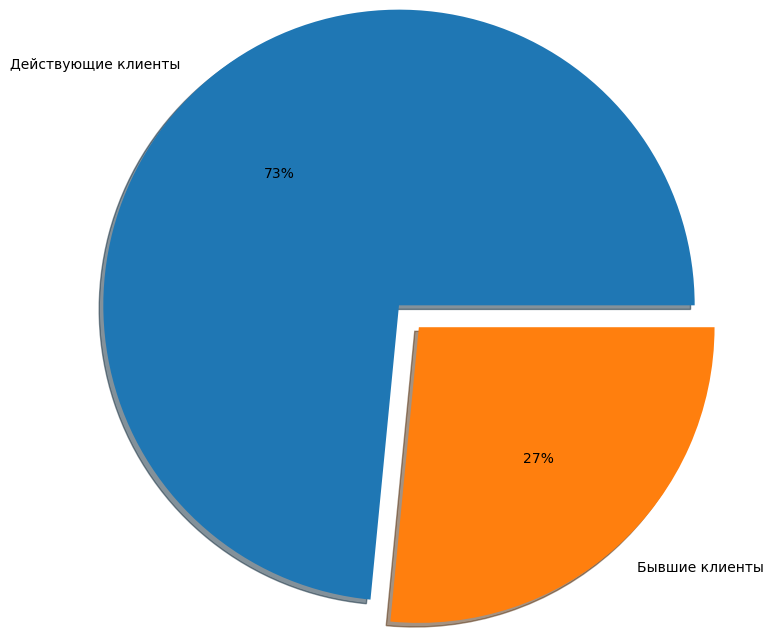

In [6]:
# функция для выделения целевого признака
def to_target(target):
    if target == 'no':
        target = 0
    else:
        target = 1
    return target

# применение функции к таблице с данными
contract['target'] = contract['end_date'].apply(to_target)
display(contract.sample(3))
# построение диаграммы-пирога
data_pie = [len(contract) - contract['target'].sum(), contract['target'].sum()]
labels = ['Действующие клиенты', 'Бывшие клиенты']
plt.figure(2) 
plt.pie(data_pie, labels=labels, shadow=True, radius=2, explode=[0.1, 0.1], autopct='%.0f%%')
plt.show()

Наглядно виден **дисбаланс** целевого класса: 73% / 27%.

Поскольку дата заключения и дата завершения контракта сами по себе являются просто днями и не представляют ценности для модели, в дальнейщем при формировании признаком посчитавем на их количество дней, которые клиенты были активны. Дествующим клиентам присвоим дату окончания сотрудничества '2020-02-01'.

In [7]:
# меняем тип на дату
contract['begin_date'] =  pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
# всем актуальными пользователям присваиваем дату, когда данные выгружены
contract.loc[contract['end_date'] == 'no', 'end_date'] = '2020-02-01'
contract['end_date'] =  pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

contract.sample(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
1297,6198-zfioj,2019-09-01,2020-02-01,month-to-month,no,electronic check,75.6,402.5,0
3814,6701-yvnqg,2014-02-01,2020-02-01,two year,yes,credit card (automatic),88.7,6301.7,0
4339,6992-tknyo,2016-12-01,2020-02-01,one year,no,credit card (automatic),69.0,2669.45,0


Проверим столбцы 'type', 'paperless_billing', 'payment_method'

In [8]:
# смотрим частоту значений
contract['type'].value_counts()

month-to-month    3875
two year          1695
one year          1473
Name: type, dtype: int64

In [9]:
contract['paperless_billing'].value_counts()

yes    4171
no     2872
Name: paperless_billing, dtype: int64

In [10]:
contract['payment_method'].value_counts()

electronic check             2365
mailed check                 1612
bank transfer (automatic)    1544
credit card (automatic)      1522
Name: payment_method, dtype: int64

В вышеперчисленных столбцах данные выглядят нормально.

Необходимо поменяем тип 'total_charges' на float. Т к изначально присвоен тип 'object', то вероятнее всего есть не только числовые значения, посмотрим:

In [11]:
contract['total_charges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

Видно, что есть пустые значения. Посмотрим на них ближе.

In [12]:
# смотрим данные с пропусками в 'total_charges'
display(contract[contract['total_charges'] == ' '].head(3))
print('Количество клиентов с пропуском в общей выручке', len(contract[contract['total_charges'] == ' ']))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
488,4472-lvygi,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,,0
753,3115-czmzd,2020-02-01,2020-02-01,two year,no,mailed check,20.25,,0
936,5709-lvoeq,2020-02-01,2020-02-01,two year,no,mailed check,80.85,,0


Количество клиентов с пропуском в общей выручке 11


Дата заключения конракта с компанией '2020-02-01', такие пропуски образовались в следствии того, что клиенты еще не успели ничего оплатить. Удалим эти 11 записей, т к никакой информации эти клиенты привнести еще не успели. 

In [13]:
# удаляем данные с пропусками
print('До удаления размер =', len(contract))
contract = contract[contract['total_charges'] != ' ']
print('После удаления размер =', len(contract))

До удаления размер = 7043
После удаления размер = 7032


### Персональные данные клиента

Згарузка и ознакомление.

In [14]:
pth3 = '/datasets/final_provider/personal.csv'
pth4 = '/Users/refresh/Downloads/final_provider/personal.csv'
if os.path.exists(pth3):
    personal = pd.read_csv(pth3)
elif os.path.exists(pth4):
    personal = pd.read_csv(pth4)
else:
    print('Что-то пошло не так')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
928,0862-PRCBS,Female,0,Yes,Yes
1830,7321-KKSDU,Male,0,No,Yes
5500,7139-JZFVG,Male,0,Yes,Yes


Видно, что данные имеют разный вид, приведем всё к "змеиному регистру". И проверим на явные дубликаты.

In [16]:
personal = personal.rename(columns = {'customerID' : 'customer_id',
                                      'SeniorCitizen' : 'senior_citizen',
                                      'Partner' : 'partner',
                                      'Dependents' : 'dependents'})
dict_to_low = ['customer_id', 'gender', 'partner', 'dependents']
personal[dict_to_low] = personal[dict_to_low].apply(lambda x: x.astype(str).str.lower())
display(personal.sample(3))
print('Дубликатов в таблице personal', personal.duplicated().sum())

,customer_id,gender,senior_citizen,partner,dependents
5368,6168-wfvvf,female,1,no,no
2901,7765-lwvvh,female,0,yes,yes
899,2267-fpima,male,0,yes,no


Дубликатов в таблице personal 0


Смотрим частоту значений в 'gender', 'senior_citizen', 'partner' и 'dependents'

In [17]:
personal['gender'].value_counts()

male      3555
female    3488
Name: gender, dtype: int64

In [18]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [19]:
personal['partner'].value_counts()

no     3641
yes    3402
Name: partner, dtype: int64

In [20]:
personal['dependents'].value_counts()

no     4933
yes    2110
Name: dependents, dtype: int64

Данные выглядят нормально.

### Информация об интернет-услугах

Згарузка и ознакомление.

In [21]:
pth5 = '/datasets/final_provider/internet.csv'
pth6 = '/Users/refresh/Downloads/final_provider/internet.csv'
if os.path.exists(pth5):
    internet = pd.read_csv(pth5)
elif os.path.exists(pth6):
    internet = pd.read_csv(pth6)
else:
    print('Что-то пошло не так')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [22]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2085,9481-WHGWY,DSL,Yes,No,No,Yes,Yes,Yes
3780,5380-AFSSK,Fiber optic,No,No,No,No,Yes,Yes
1730,5931-FLJJF,Fiber optic,No,No,No,No,No,No
1147,3253-HKOKL,Fiber optic,Yes,No,Yes,No,Yes,Yes
5109,3439-GVUSX,DSL,No,No,No,No,No,No


In [23]:
internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Видно, что данные имеют разный вид, приведём всё к "змеиному регистру". И проверим на явные дубликаты.

In [24]:
internet = internet.rename(columns = {'customerID' : 'customer_id',
                                      'InternetService' : 'internet_service',
                                      'OnlineSecurity' : 'online_security',
                                      'OnlineBackup' : 'online_backup',
                                      'DeviceProtection' : 'device_protection',
                                      'TechSupport' : 'tech_support',
                                      'StreamingTV' : 'streaming_tv',
                                      'StreamingMovies' : 'streaming_movies'})
internet = internet.apply(lambda x: x.astype(str).str.lower())
display(internet.sample(3))
print('Дубликатов в таблице internet', internet.duplicated().sum())

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
197,0322-yinqp,dsl,yes,no,no,no,no,no
4377,7228-omtpn,fiber optic,no,no,no,no,yes,yes
874,7439-dkztw,fiber optic,no,no,no,no,yes,no


Дубликатов в таблице internet 0


Данные выглядят хорошо.

### Информация об услугах телефонии

Згарузка и ознакомление.

In [25]:
pth7 = '/datasets/final_provider/phone.csv'
pth8 = '/Users/refresh/Downloads/final_provider/phone.csv'
if os.path.exists(pth7):
    phone = pd.read_csv(pth7)
elif os.path.exists(pth8):
    phone = pd.read_csv(pth8)
else:
    print('Что-то пошло не так')
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [26]:
phone.sample(5)

,customerID,MultipleLines
305,9639-BUJXT,No
610,2324-AALNO,Yes
2149,7089-RKVSZ,Yes
3862,1087-UDSIH,No
3130,5996-NRVXR,No


Видно, что данные имеют разный вид, приведём всё к "змеиному регистру". И проверим на явные дубликаты.

In [27]:
phone = phone.rename(columns = {'customerID' : 'customer_id',
                                'MultipleLines' : 'multiple_lines'})
phone = phone.apply(lambda x: x.astype(str).str.lower())
display(phone.sample(3))
print('Дубликатов в таблице phone', phone.duplicated().sum())

,customer_id,multiple_lines
3833,5457-colht,no
6059,2027-cwdnu,no
4364,4948-wbbkl,yes


Дубликатов в таблице phone 0


Проверим значения 'multiple_lines'

In [28]:
phone['multiple_lines'].value_counts()

no     3390
yes    2971
Name: multiple_lines, dtype: int64

Данные в норме.

### Вывод

Данные загружены, проведено ознакомление. Присутствовало незначительное количество пропусков, которые я убрал. Привёл все данные к единому стилю, чтобы отчет был более читаемым и с данными было удобнее работать. Проверил на дубликаты. Типы данных привёл к соответсвующим информации. В таблицах разное количество данных, это можно объяснить тем, что не все клиенты пользуются всеми услугами.
Выделил целевой признак - покинул клиент компанию или нет. В цлевом признаке есть дисбаланс 73% / 27% (ушедших клиентов меньше).

Все готово к дальнейшему исследованию.

## Соединение таблиц и создание признаков

Для начала создадим новый признак, который является важной метрикой в бизнесе - количество дней, которые клиент был активным.

In [29]:
# функция для рассчета количества дней, которые пользователь был активным
def to_day(row):
    date_0 = row['end_date']
    date_1 = row['begin_date']
    return (date_0 - date_1).days
# расчет активных дней
contract['avg_month'] = contract.apply(to_day, axis=1)

Чтобы сделать признаки удобными для модели соединим их в одну таблицу по полю "customer_id".

In [30]:
all_info = contract.merge(personal, on='customer_id', how='left')
all_info = all_info.merge(internet, on='customer_id', how='left')
all_info = all_info.merge(phone, on='customer_id', how='left')

In [31]:
all_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   object        
 8   target             7032 non-null   int64         
 9   avg_month          7032 non-null   int64         
 10  gender             7032 non-null   object        
 11  senior_citizen     7032 non-null   int64         
 12  partner            7032 non-null   object        
 13  dependents         7032 non-null   object        
 14  internet

В таблице появились пропуски - это, пердположительно происходит потому, что некоторые клиенты пользуются не всеми услугами. Заполним пропуски значением "no", по аналогии с другими категориальными данными.

In [32]:
# заполняем прорпуски
all_info = all_info.fillna('no')
all_info['total_charges'] = all_info['total_charges'].astype('float64')

In [33]:
all_info.sample(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,avg_month,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3379,7526-bezqb,2018-12-01,2019-12-01,month-to-month,yes,electronic check,96.05,1148.10,1,365,...,no,no,fiber optic,no,no,no,no,yes,yes,yes
3527,4318-rajvy,2019-04-01,2020-02-01,one year,yes,mailed check,19.80,198.25,0,306,...,no,no,no,no,no,no,no,no,no,no
3912,9025-aomki,2019-05-01,2019-11-01,month-to-month,yes,bank transfer (automatic),93.55,536.40,1,184,...,no,no,fiber optic,no,no,no,no,yes,yes,yes


Далее проверим все признаки на мультколлинеарность и корреляцию с целевым признаком. Для удобсва выведем хитмэп:

In [34]:
# отключаем предупреждения
warnings.filterwarnings('ignore')
# удалим даты и id клиента
all_info_corr = all_info.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
phik_overview = all_info_corr.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'avg_month', 'senior_citizen']


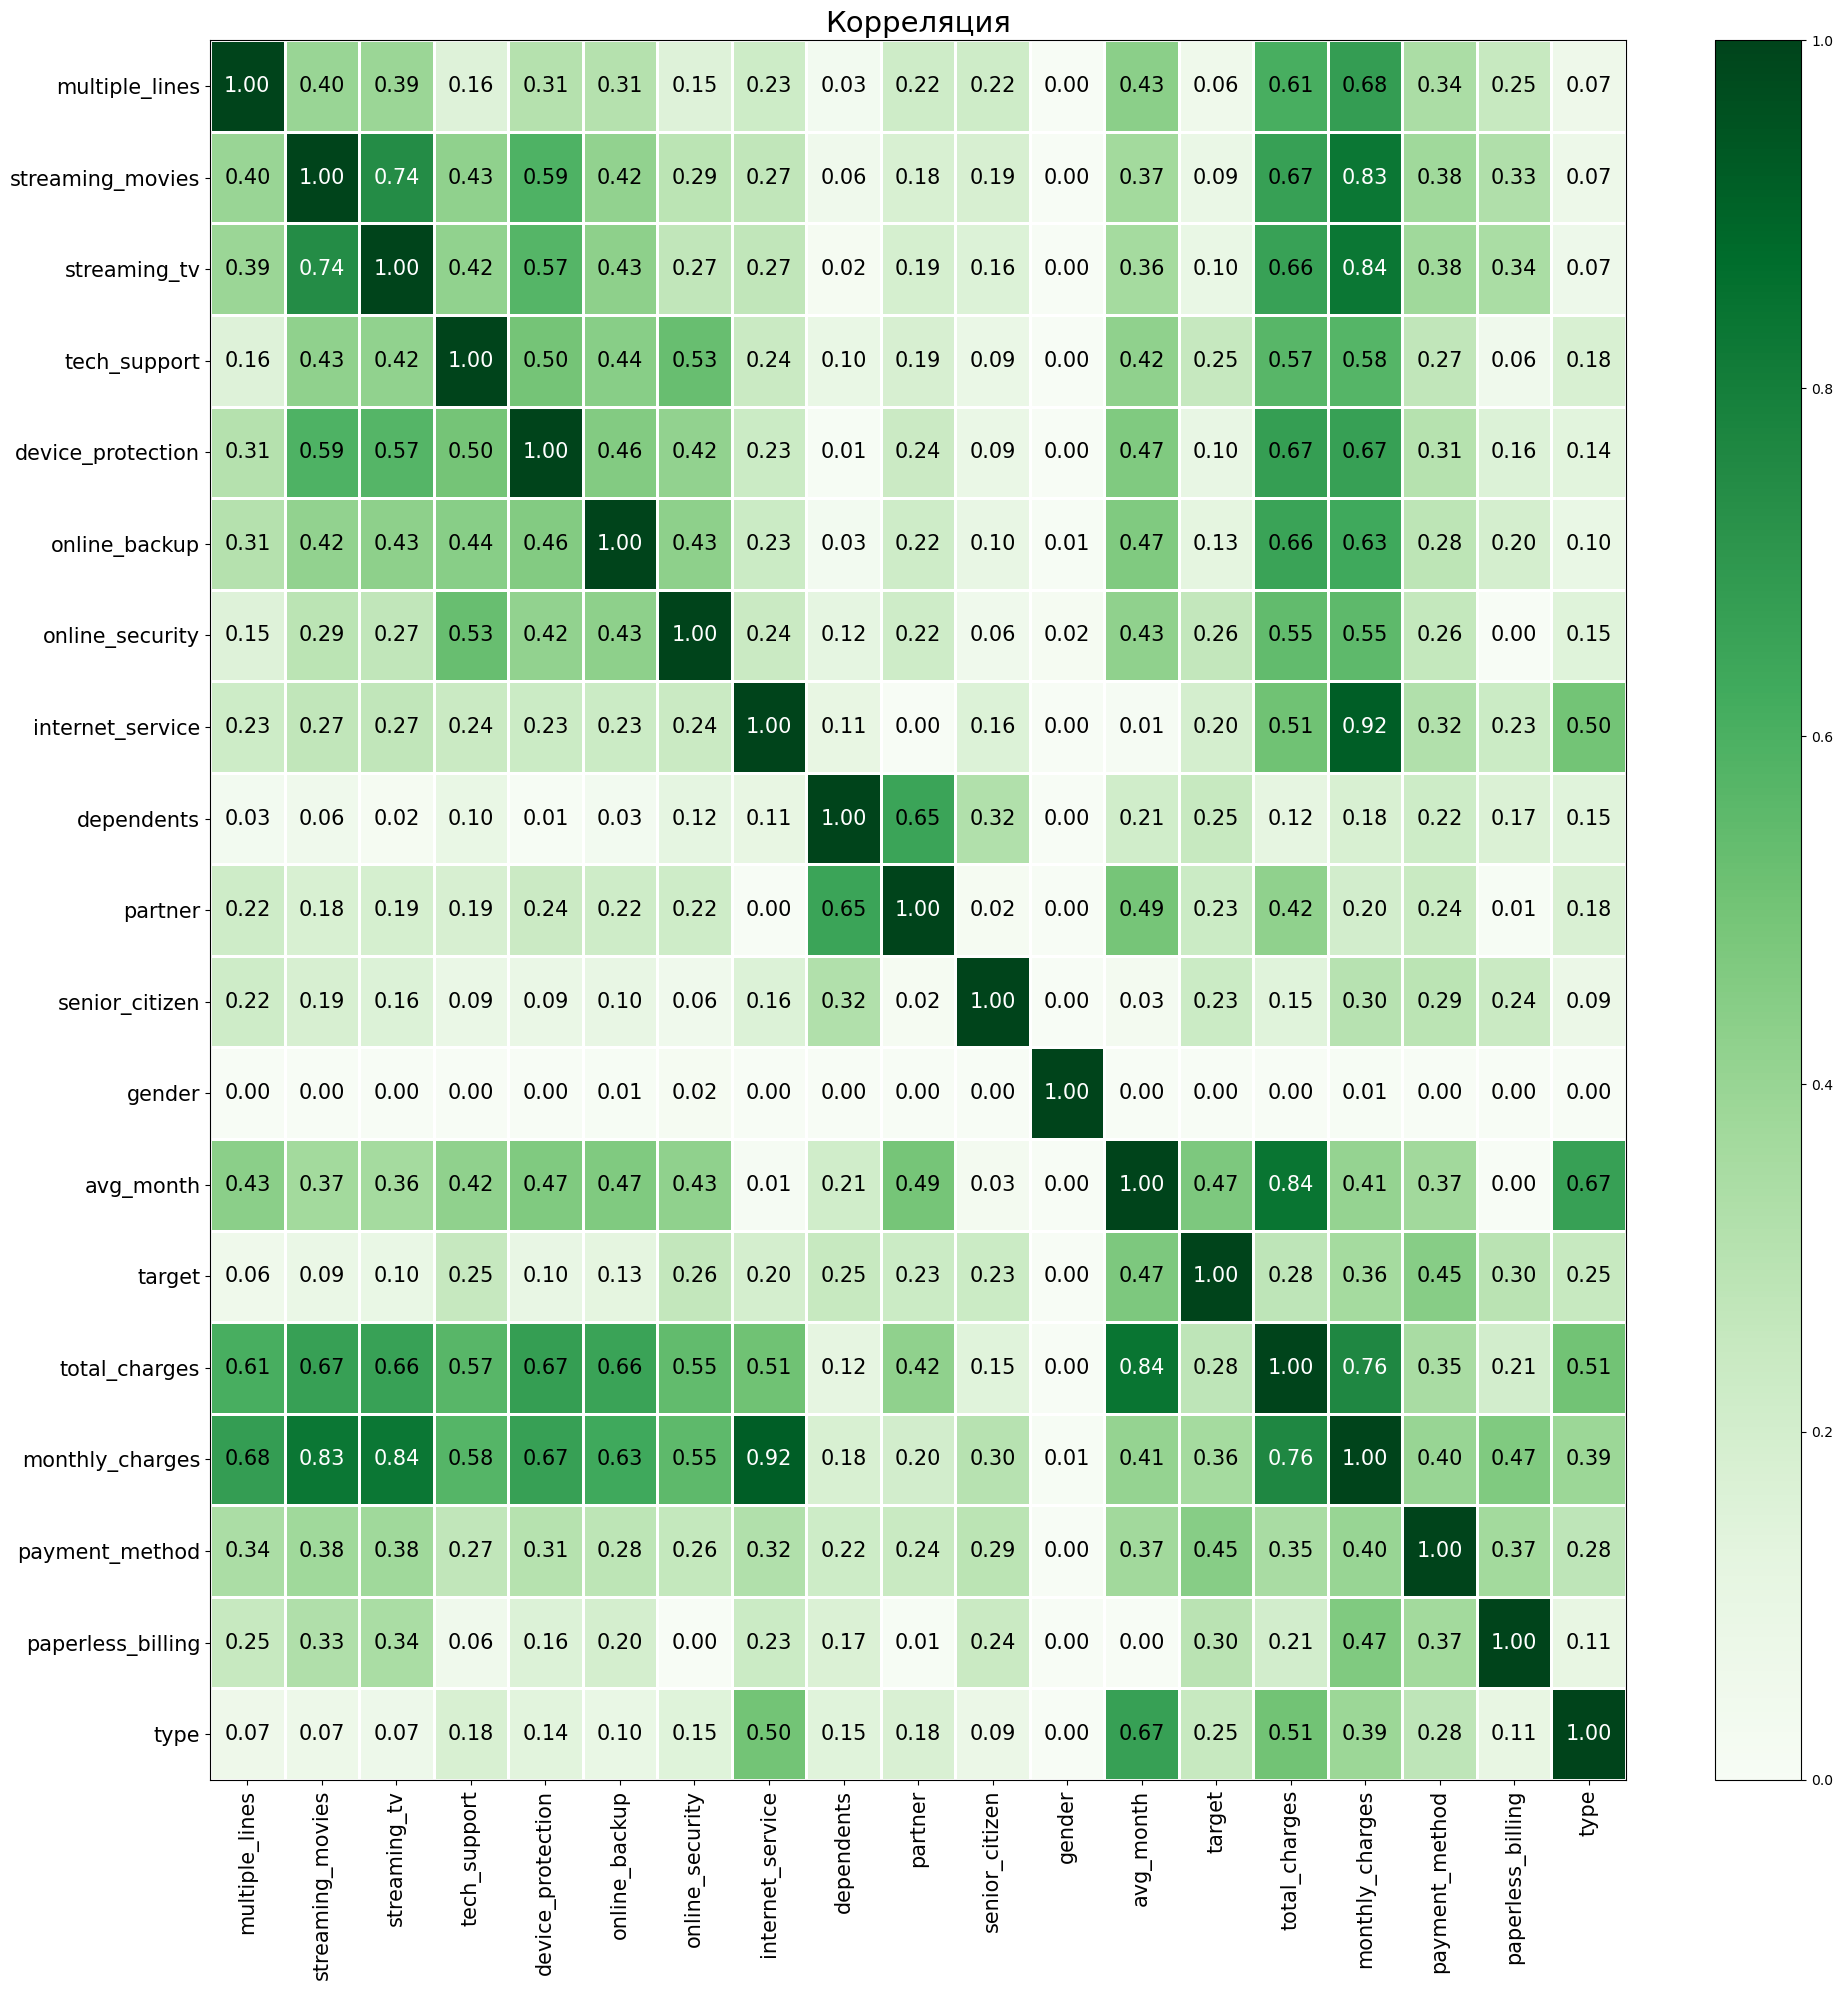

In [35]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title='Корреляция', 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

Наблюдается высокая корреляция у признака 'количество активных дней в компании' и признаков связанных с телевидением, кино и нитернетом, что логично, раз люди платят за них, то они и отображаются в данных.

Так же высокая корреляция у признака 'общая выручка', здесь аналогичные с прошлым признаком причны.

Высокая корреляция с целевым признаком ни у одного признака не наблюдается.

Разделяем данные на признаки и целевой признак. Считаю, что id клиента и даты начала и конца сотрудничества не информативны для модели - удалим их.

In [36]:
# формируем признаки и целевой признак
X = all_info.drop(['customer_id', 'begin_date', 'end_date', 'target'], axis=1)
y = all_info['target']

Делим сформированные данные на обучающую и тестовую выборки в соотношении 3/1. Т к есть дисбаланс - старифицируем, чтобы оба класса присутсвовали и в обучении и в тесте.

In [37]:
# разбивает на трэйн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=281122,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5274, 18), (1758, 18), (5274,), (1758,))

### Вывод

Создал новый признак, который является важной метрикой в бизнесе - количество дней, которые клиент был активным.
Объединил данные одну таблицу по полю "customer_id". Появились пропуски - это, пердположительно происходит потому, что некоторые клиенты пользуются не всеми услугами. Заполнил пропуски значением "no", по аналогии с другими категориальными данными.

Проверим все признаки на мультколлинеарность и корреляцию с целевым признаком.
Наблюдается высокая корреляция у признака 'ежемесячные траты' и признаков связанных с телевидением, кино и нитернетом, что логично, раз люди платят за них, то они и отображаются в данных. Так же высокая корреляция у признака 'общая выручка', здесь аналогичные с прошлым признаком причны. Высокая корреляция с целевым признаком ни у одного признака не наблюдается.

Разделил данные на признаки и целевой признак. Удалил не информативны для модели данные.

Разделил данные на обучающую и тестовую выборки в соотношении 3/1, дисбаланс учтён.

## Обучение моделей

### LGBMClassifier

Для моделей с грдиентным бустингом закодируем данные. Для этого выделим типы признаков:

    - категориальные, их кодируем с помощью OrdinalEncoder,
    - чистовые, их с помощью StandardScaler.
    
и запустим перебор паматретров на GridSearchCV.

In [38]:
X_train_boost= X_train.copy()
X_test_boost = X_test.copy()
# кодируем признаки для гордиентного бустинга
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents',
                'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                'online_security', 'streaming_tv', 'streaming_movies', 'multiple_lines']
num_features = ['monthly_charges', 'total_charges', 'avg_month']

In [39]:
%%time

encoder = OrdinalEncoder()
scaler = StandardScaler()

model_LGBM = LGBMClassifier(random_state=281122)
grid = {'model__n_estimators': [50, 100, 200],
        'model__max_depth': [4, 8, 12],
        'model__learning_rate': [0.05, 0.1]}

# создаем пайплайн для кодирования
col_transformer = ColumnTransformer([('categorical', encoder, cat_features), 
                                     ('numeric', scaler, num_features)])

# создаем пайплайн для грид сёрч
pl = Pipeline([('transformer', col_transformer),
               ('model', model_LGBM)])

# кроссвалидация с подбором параметров
grid_LGBM = GridSearchCV(pl, grid, cv=5, scoring='roc_auc', n_jobs=-1)
model_LGBM = grid_LGBM.fit(X_train_boost, y_train)
print(f'Лучшие параметры модели {model_LGBM.best_params_}')
print('roc_auc', abs(model_LGBM.best_score_))

Лучшие параметры модели {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 200}
roc_auc 0.8880862705762868
CPU times: user 3.7 s, sys: 172 ms, total: 3.87 s
Wall time: 7.1 s


### CatBoostClassifier

Признаки используем в том же виде, что и для прошлой модели. И так же запускаем GridSearchCV.

In [40]:
%%time

model_cat = CatBoostClassifier(random_state=281122, verbose=False)

# создаем пайплайн для кодирования
col_transformer = ColumnTransformer([('categorical', encoder, cat_features), 
                                     ('numeric', scaler, num_features)])

# создаем пайплайн для грид сёрч
pl = Pipeline([('transformer', col_transformer),
               ('model', model_cat)])

# кроссвалидация с подбором параметров
grid_cat = GridSearchCV(pl, grid, cv=5, scoring='roc_auc', n_jobs=-1)
model_cat = grid_cat.fit(X_train_boost, y_train)

print(f'Лучшие параметры модели {model_cat.best_params_}')
print('roc_auc', abs(model_cat.best_score_))

Лучшие параметры модели {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
roc_auc 0.8902226682899329
CPU times: user 6.26 s, sys: 534 ms, total: 6.79 s
Wall time: 1min 26s


### LogisticRegression

Для линейной модели закодируем немного по-другому:

    - категориальные, их кодируем с помощью OneHotEncoder,
    - чистовые, их с помощью StandardScaler.

In [41]:
%%time

X_train_log = X_train.copy()
X_test_log = X_test.copy()

ohe = OneHotEncoder(drop = 'first')

model_log = LogisticRegression(random_state=281122)
grid_log = {'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'model__penalty':['none', 'elasticnet', 'l1', 'l2'],
            'model__C':[0.001, 0.01, 0.1, 1, 10, 100]}

# создаем пайплайн для кодирования
col_transformer = ColumnTransformer([('categorical', ohe, cat_features), 
                                     ('numeric', scaler, num_features)])

# создаем пайплайн для грид сёрч
pl = Pipeline([('transformer', col_transformer),
               ('model', model_log)])

# кроссвалидация с подбором параметров
grid_log = GridSearchCV(pl, grid_log, cv=5, scoring='roc_auc', n_jobs=-1)
model_log = grid_log.fit(X_train_log, y_train)
print(f'Лучшие параметры модели {model_log.best_params_}')
print('roc_auc', abs(model_log.best_score_))

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linea

Лучшие параметры модели {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
roc_auc 0.8419187459422048
CPU times: user 21.3 s, sys: 1.05 s, total: 22.4 s
Wall time: 25.5 s


###  Вывод

Признаки подготовлены соответсвенно используемым моделям, результаты следующие:

- LGBMClassifier 

  Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
  roc_auc 0.88
  
  
- CatBoostClassifier

  Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
  roc_auc 0.89
  
  
- LogisticRegression

  Лучшие параметры модели {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
  roc_auc 0.84

## Проверка лучшей модели на тесте

Тк лучшую метрику показал CatBoostClassifier, проверим её на тесте. Посчитаем дополнительно метрики F1 и Accuracy.

В дополнение выясним какие признаки получили наибольшую значимость.

roc_auc_score 0.9084370962204158
f1_score 0.7055961070559611
accuracy_score 0.8623435722411832


,feature_importance,feature_names
22,56.727531,numeric__avg_month
10,6.570624,categorical__internet_service_fiber optic
21,6.544125,numeric__total_charges
20,6.304670,numeric__monthly_charges
1,6.220623,categorical__type_two year
11,2.776830,categorical__internet_service_no
0,2.471117,categorical__type_one year
2,1.687131,categorical__paperless_billing_yes
4,1.533733,categorical__payment_method_electronic check
9,0.971129,categorical__dependents_yes


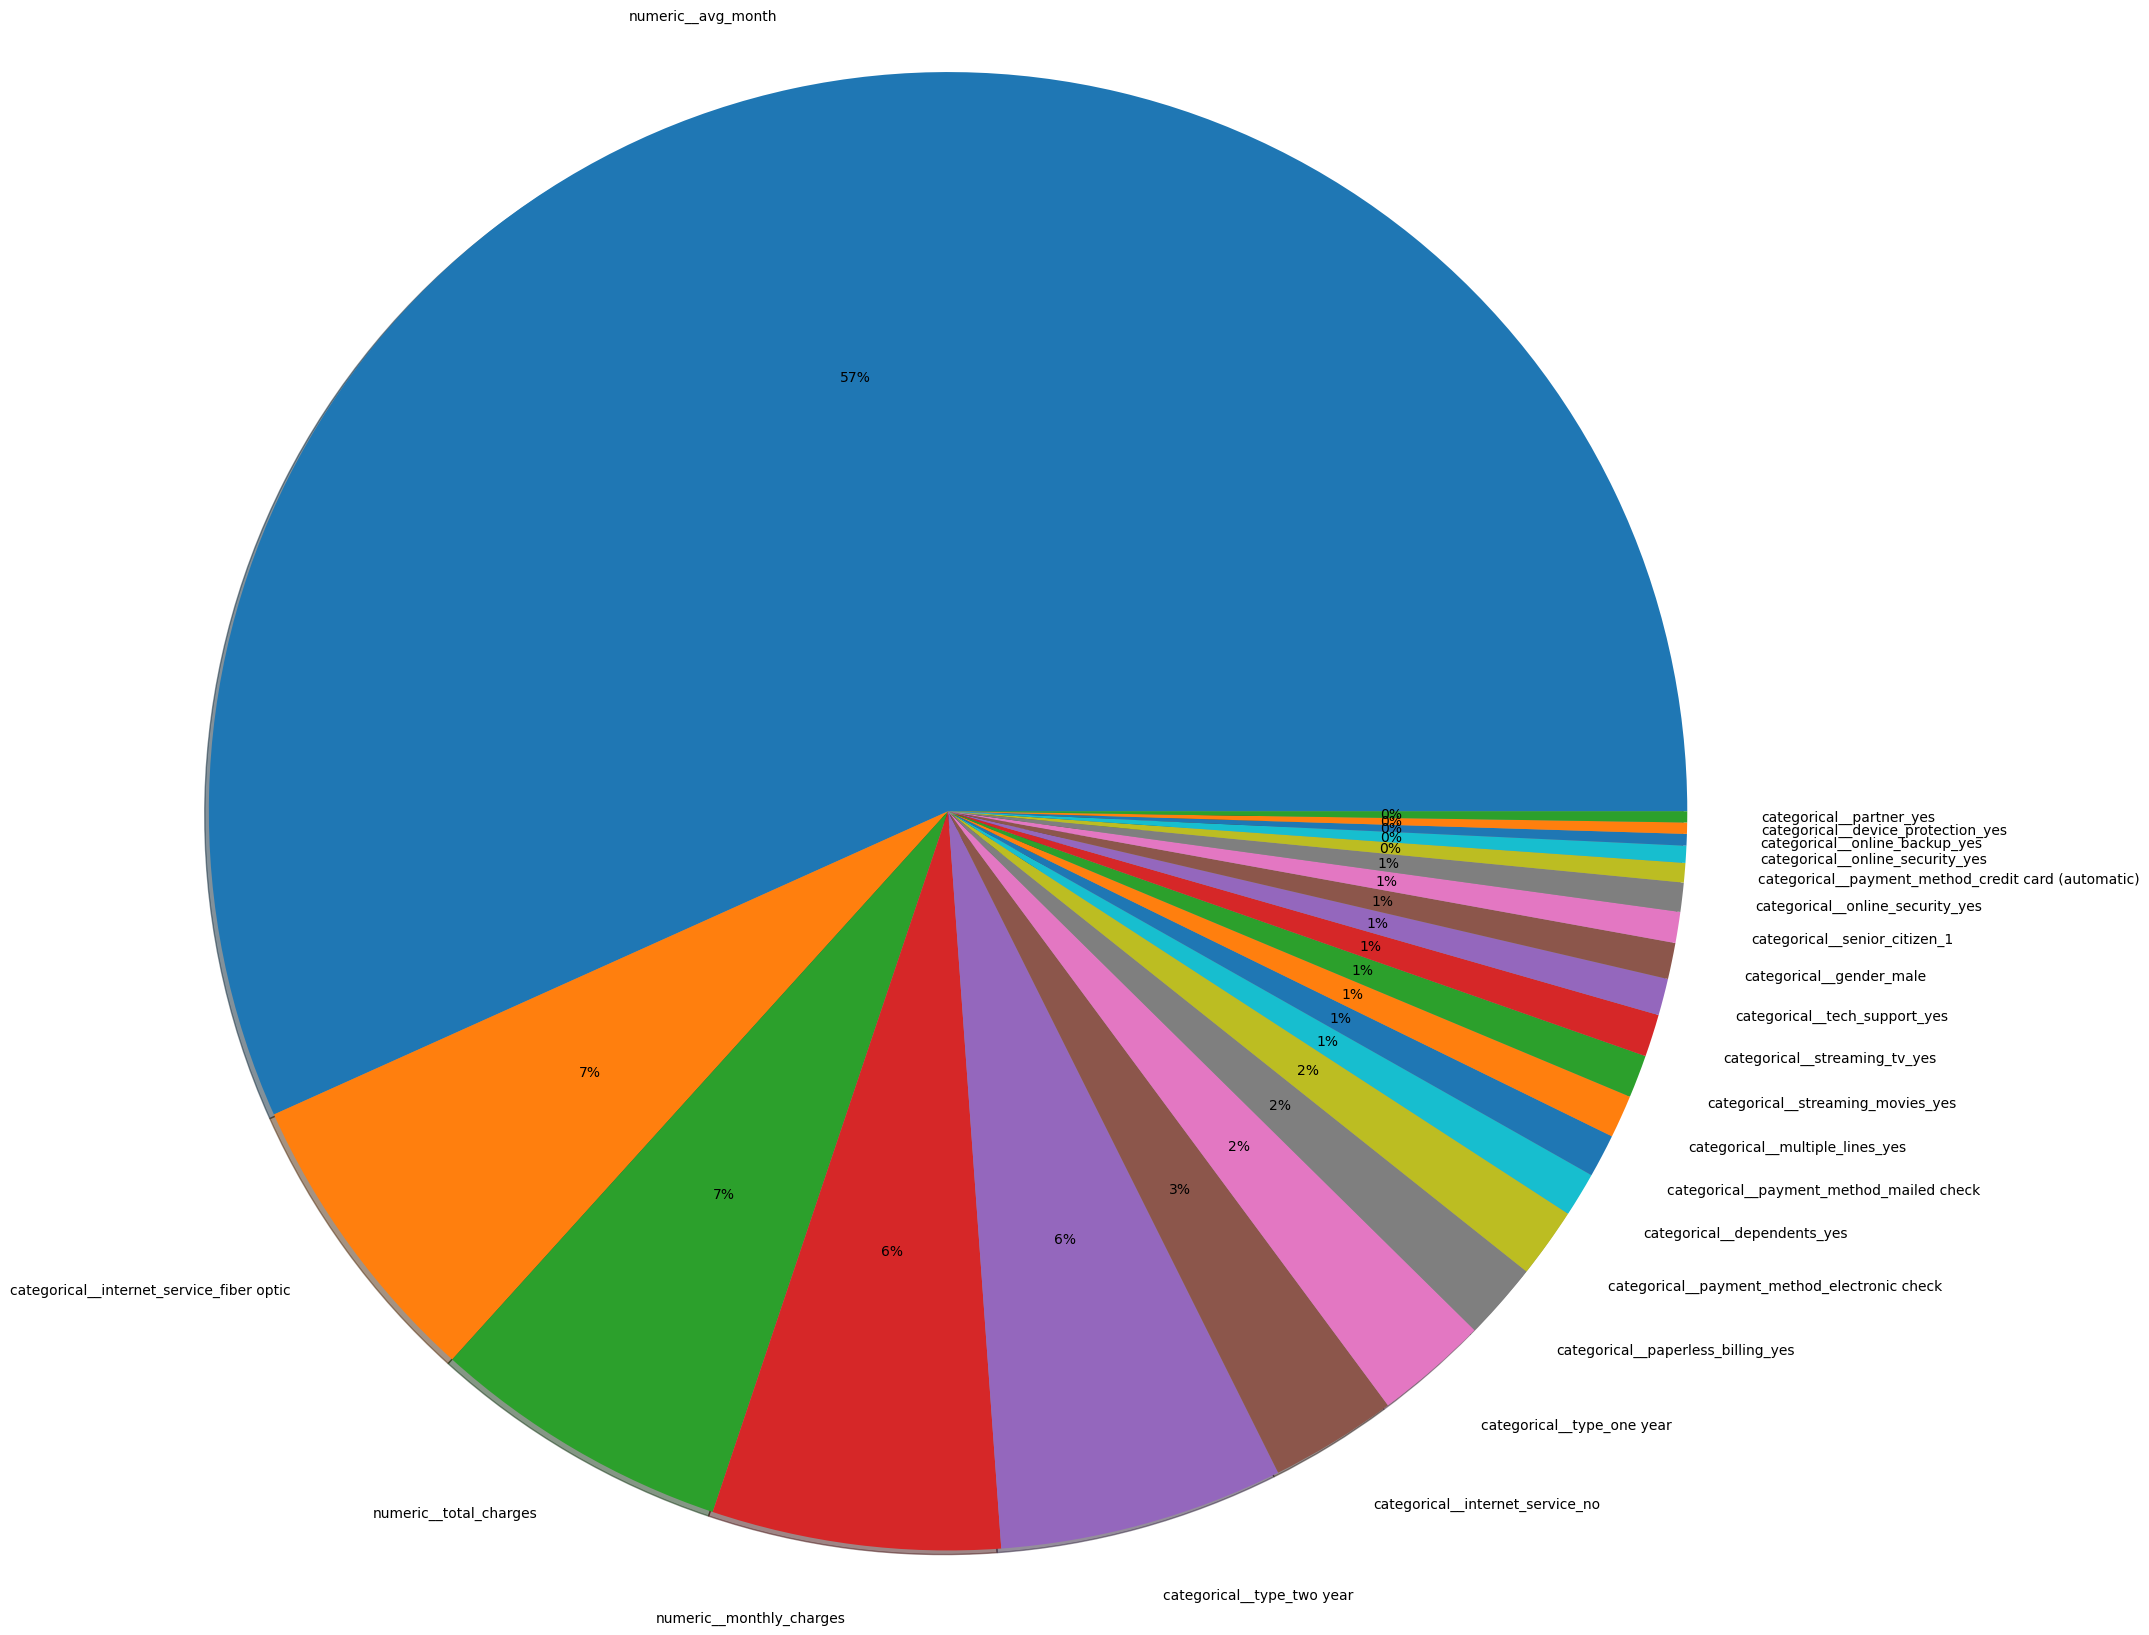

In [42]:
# создоём модель, обучаем и предсказываем
model_finish = CatBoostClassifier(random_state=281122, verbose=False, learning_rate=0.1, max_depth=4, n_estimators=200)
# создаем пайплайн для грид сёрч
pl = Pipeline([('transformer', col_transformer),
               ('model', model_finish)])
model_finish = pl.fit(X_train_boost, y_train)
predict = model_finish.predict(X_test_boost)
predict_probs = model_finish.predict_proba(X_test_boost)
# сохраняем вероятности только для положительного исхода
predict_probs = predict_probs[:, 1]
# рассчитываем метрики
print('roc_auc_score', roc_auc_score(y_test, predict_probs))
print('f1_score', f1_score(y_test, predict))
print('accuracy_score', accuracy_score(y_test, predict))
# выводим признаки
importance = pd.DataFrame({'feature_importance': model_finish[1].get_feature_importance(), 
                           'feature_names': model_finish[0].get_feature_names_out()}).sort_values(by=['feature_importance'], ascending=False)
display(importance)

# построение диаграммы-пирога
plt.figure(2) 
plt.pie(importance.feature_importance, labels=importance.feature_names, shadow=True, radius=5, autopct='%.0f%%')
plt.show()

Строим ROC-кривую.

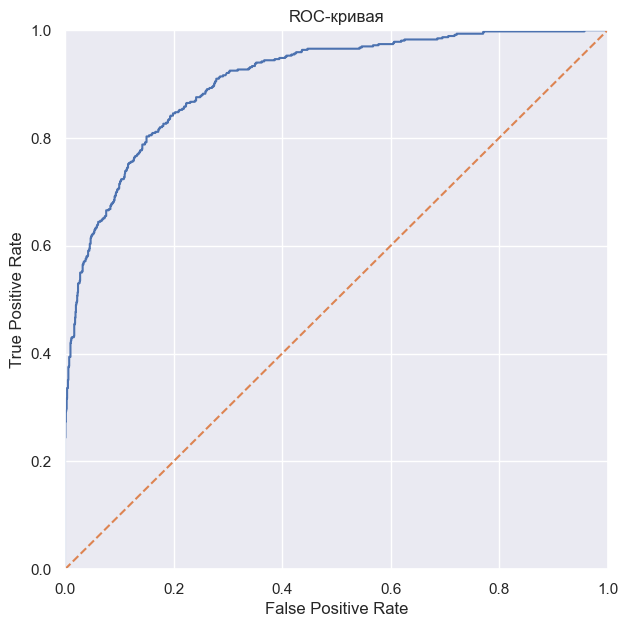

In [43]:
# строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, predict_probs)
sns.set_theme(style='darkgrid')
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, linestyle='-');

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--');
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show();

Видно, что модель отлично справилась с тестом и выглядит намного эффективнее случайной модели. Опишем результаты в финальном выводе.

## Вывод по исследованию

Исследование проведено в четыре этапа:

1.	Данные загружены, проведено ознакомление. Привёл все данные к единому стилю, чтобы отчет был более читаемым и с данными было удобнее работать. Проверил на дубликаты. При приведении типов данных к соответствующим информации выяснилось, что вместо пропусков присутствуют пробелы, которые соответсвуют новым клиентам, тк они не несут в себе информации – я их удалил. В таблицах разное количество данных, это можно объяснить тем, что не все клиенты пользуются всеми услугами. Выделил целевой признак - покинул клиент компанию или нет. В целевом признаке есть дисбаланс 73% / 27% (ушедших клиентов меньше).


2.	В начале я предполагал запустить модели на все той информации, которая была изначально и посмотреть на метрики, но в процессе понял, что даты не несут важной информации, а сколько клиенты был дней в компании – это важная информация. Поэтому я создал новый признак – количество дней, которые клиент был активным. В дальнейшем, если бы метрики не доходили до заданного значения, я предполагал создать еще признаки, например, классификацию клиентов на группы по платежам, среднемесячная выручка с каждого клиента. Объединил данные в одну таблицу по полю "customer_id". Появились пропуски - это, предположительно происходит потому, что некоторые клиенты пользуются не всеми услугами. Заполнил пропуски значением "no", по аналогии с другими категориальными данными. Проверил все признаки на мультколлинеарность и корреляцию с целевым признаком, никаких неожиданных аномалий не выяснил. Наблюдается высокая корреляция у признака 'кол-во дней, которые клиент был актиным' и признаков, связанных с телевидением, кино и интернетом, что логично, раз люди платят за них, то они и отображаются в данных. Так же высокая корреляция у признака 'общая выручка', здесь аналогичные с прошлым признаком причины. Высокая корреляция с целевым признаком ни у одного признака не наблюдается. Разделил данные на признаки и целевой признак. Удалил не информативны для модели данные. Разделил данные на обучающую и тестовую выборки в соотношении 3/1, дисбаланс учтён.


3.	В начале я планировал попробовать модели основанные на градиентном бустинге, т к они хорошо справляются с табличными данными, и использовать одну простую модель, для сравнения. Нейронные сети к данной задаче я бы пробовал, если метрика не могла бы дойти до заданной, на мой взгляд, они слишком «нагруженные» для этой задачи. В ходе подготовки признаков возникла проблема с линейной моделью: техника кодирования get_dummies могла привести к тому, что тренировочная и тестовая выборки могут не совпадать по выходным столбцам и требуется дополнительная проверка. Решением послужило кодирование с помощью OneHotEncoder. В результате бустинг, как и предполагалось, показала хорошие метрики и потребность в других моделях отпала:


 •	LGBMClassifier для подбора параметров требует 2.13 минут. Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200} roc_auc 0.88
 
 •	CatBoostClassifier для подбора параметров требует 1.63 минут. Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200} roc_auc 0.89
 
 •	LogisticRegression для подбора параметров требует 0.21 минут. Лучшие параметры модели {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'} roc_auc 0.84
 
 
4.	Лучшая модель CatBoostClassifier на тесте показала следующие результаты по метрикам:

 •	roc_auc_score 0.90
 
 •	f1_score 0.70
 
 •	accuracy_score 0.86

Построенная модель предсказывает уход клиента с вероятностью 86%. Модель заметно отличается от случайной модели в лучшую сторону, а главная метрика даже немного увеличилась AUC-ROC = 0.9. Соотношение точности и полноты 70%.
Самым важным признаком получился созданный признак "количество дней, которое клиент был активным", что логично: чем больше клиент в компании, тем он лояльнее. Далее идёт признак "тип оплаты" - если клиент оплачивает сразу год, он не думает в ближайшее время уходить. Далее следую признаки, связанные со стоимостью услуг за месяц, и общая выручка за все услуги с клиента. Всё это указывает на то, что показатели, связанные с продолжительностью сотрудничества и деньгами, говорят о лояльности клиентов.
Возможно предложить клиентам промокоды на оплату за год, полгода или оплату допуслуг, тк если клиент начинает платить больше - вероятность его ухода снижается.